In [2]:
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, Activation, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Conv2DTranspose, Input, UpSampling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

Using TensorFlow backend.


## Data Import

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 2s 1us/step


In [0]:
images = np.concatenate((train_images, test_images), axis = 0)
labels = np.concatenate((train_labels, test_labels), axis = 0)

### Plotting Examples of All 10 Classes

In [0]:
observed, indexes = [], []
for i in range(len(labels)):
    if train_labels[i] not in observed:
        observed.append(labels[i])
        indexes.append(i)
    if len(observed) == 10:
        break

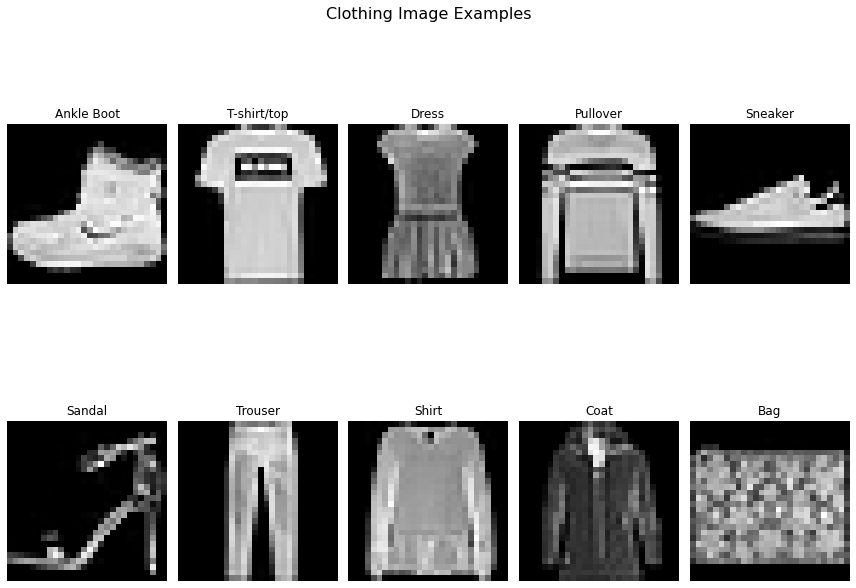

In [6]:
plt.rcParams["figure.figsize"] = (12, 10)
fig, axs = plt.subplots(2,5)
fig.suptitle('Clothing Image Examples', fontsize = 16)

titles = ["Ankle Boot", "T-shirt/top", "Dress", "Pullover", "Sneaker",
          "Sandal", "Trouser", "Shirt", "Coat", "Bag"]

for i in range(5):
    axs[0, i].imshow(images[indexes[i]], cmap = 'gray')
    axs[0, i].set_title(titles[i])
    axs[1, i].imshow(images[indexes[i + 5]], cmap = 'gray')
    axs[1, i].set_title(titles[i + 5])
    axs[0, i].axis('off')
    axs[1, i].axis('off')

fig.tight_layout()
plt.show()

### Initializations

In [0]:
images = images.reshape((70000, 28, 28, 1)).astype('float32') / 255
row_num, col_num = 28, 28
latent_dim = 100

### Generator

In [0]:
def build_generator():
    mod = Sequential()
    
    ### Generate Random Noise ###
    mod.add( Dense(7 * 7 * 128, input_dim = latent_dim) )
    mod.add( Reshape((7, 7, 128)) )

    ### Convolution Transpose Layers ###
    mod.add( UpSampling2D() )
    mod.add( Conv2D(128, 3, padding = 'same') )
    mod.add( BatchNormalization(momentum = 0.9) )
    mod.add( Activation('relu') )
    mod.add( UpSampling2D() )
    mod.add( Conv2D(64, 3, padding = 'same') )
    mod.add( BatchNormalization(momentum = 0.9) )
    mod.add( Activation('relu') )
    mod.add( Conv2D(1, 3, padding = 'same') )
    mod.add( Activation('sigmoid') )
    
    ### Generator Summary ###
    print("Generator Summary")
    mod.summary()
    print(" ")
    
    noise = Input(shape = (latent_dim,))
    img = mod(noise)
    
    return( Model(noise, img) )

### Discriminator

In [0]:
def build_discriminator():
    mod = Sequential()

    ### Convolutional Layers ###
    mod.add( Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)) ) 
    mod.add( MaxPooling2D((2, 2)) )
    mod.add( Conv2D(64, (3, 3), activation = 'relu') ) 
    mod.add( MaxPooling2D((2, 2)) )
    mod.add( Conv2D(64, (3, 3), activation = 'relu') )

    ### Multi Layer Perceptron ###
    mod.add( Flatten() ) 
    mod.add( Dense(64, activation = 'relu') )
    mod.add( Dense(1, activation = 'sigmoid') )
    
    ### Discriminator Summary ###
    print("Discriminator Summary")
    mod.summary()
    print(" ")
    
    img = Input(shape = (28, 28, 1))
    validity = mod(img)
    
    return( Model(img, validity) )

### Combined Model

In [10]:
### Compile Discriminator ###
discriminator = build_discriminator()
discriminator.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

### Feeding Noise to Generator ###
generator = build_generator()
z = Input(shape = (latent_dim,))
img = generator(z)

### Only Training Generator ###
discriminator.trainable = False

### Feeding Fake Image to Discriminator ###
valid = discriminator(img)

### Stacking Discriminator and Generator (Adversarial Model)
combined = Model(z, valid)
combined.compile(loss = 'binary_crossentropy', 
                 optimizer = 'adam')

Discriminator Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (No

### Model Training

In [11]:
batch_size = 64 # setting batch size
valid, fake = np.ones((batch_size, 1)), np.zeros((batch_size, 1))
test_noise = np.random.normal(0, 1, (10, latent_dim))
gen_img_store = []
d_loss_store, d_acc_store, g_loss_store = [], [], []
for epoch in range(10001):
    # Select random images
    idx = np.random.randint(0, images.shape[0], batch_size)
    imgs = images[idx]
    
    # Generate images based on random noise
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)
    
    # Train discriminator (Real Image = 1, Fake = 0)
    discriminator_loss_real = discriminator.train_on_batch(imgs, valid)
    discriminator_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
    
    # Train generator
    generator_loss = combined.train_on_batch(noise, valid)
    
    d_loss = np.round(discriminator_loss[0], 3)
    d_accuracy = np.round(100 * discriminator_loss[1], 3)
    g_loss = np.round(generator_loss, 3)
    d_loss_store.append(d_loss)
    d_acc_store.append(d_accuracy)
    g_loss_store.append(g_loss)
    
    if epoch % 500 == 0:
        gen_images = generator.predict(test_noise)
        gen_img_store.append(gen_images)
        # Print Losses
        print("Epoch = {}, D Loss: {}, D Accuracy: {}, G Loss: {}".format(
            epoch, d_loss, d_accuracy, g_loss))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch = 0, D Loss: 0.753000020980835, D Accuracy: 21.094, G Loss: 0.5929999947547913
Epoch = 500, D Loss: 0.6610000133514404, D Accuracy: 64.062, G Loss: 1.5180000066757202
Epoch = 1000, D Loss: 0.18299999833106995, D Accuracy: 91.406, G Loss: 2.372999906539917
Epoch = 1500, D Loss: 0.41999998688697815, D Accuracy: 80.469, G Loss: 1.965000033378601
Epoch = 2000, D Loss: 0.414000004529953, D Accuracy: 85.156, G Loss: 1.9809999465942383
Epoch = 2500, D Loss: 0.4090000092983246, D Accuracy: 77.344, G Loss: 1.4459999799728394
Epoch = 3000, D Loss: 0.4009999930858612, D Accuracy: 83.594, G Loss: 2.2309999465942383
Epoch = 3500, D Loss: 0.34599998593330383, D Accuracy: 84.375, G Loss: 2.015000104904175
Epoch = 4000, D Loss: 0.3440000116825104, D Accuracy: 83.594, G Loss: 2.0209999084472656
Epoch = 4500, D Loss: 0.4020000100135803, D Accuracy: 81.25, G Loss: 1.7489999532699585
Epoch = 5000, D Loss: 0.31700000166893005, D Accuracy: 85.938, G Loss: 2.0820000171661377
Epoch = 5500, D Loss: 0.374

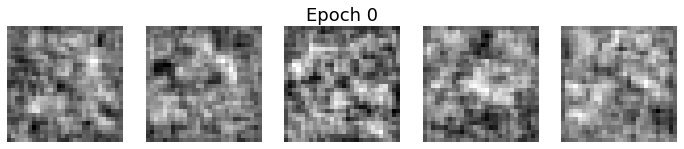

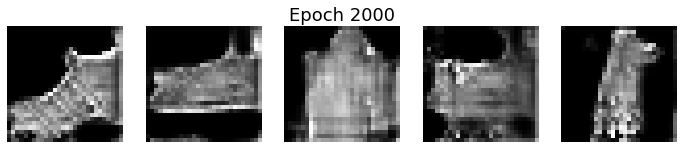

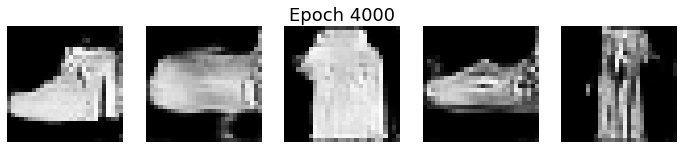

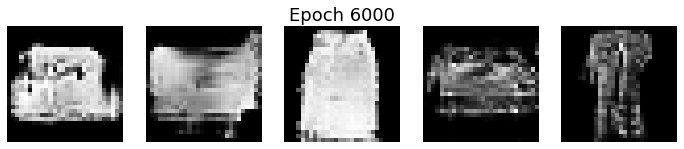

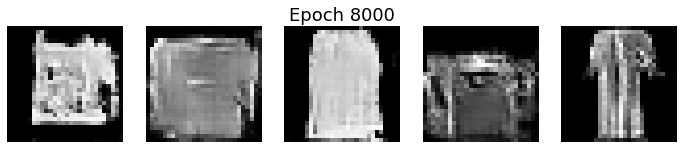

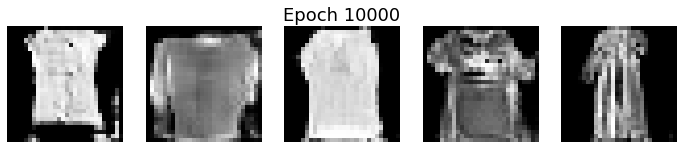

In [13]:
epoch_count = 0
for k in range(0, 21, 4):
    gen_images = gen_img_store[k]
    fig, axs = plt.subplots(1, 5)
    count = 0
    for j in range(5):
        axs[j].imshow(gen_images[count, :, :, 0], cmap = 'gray')
        count += 1
        axs[j].axis('off')
    axs[2].set_title("Epoch {}".format(epoch_count), fontsize = 18)
    epoch_count += 2000